<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B28_1%5D_Filter_Visualization_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Visualisasi Filter

Convolutional Neural Network biasanya memiliki beberapa lapisan convolutional

Secara konseptual, kita memahami bahwa setiap lapisan konvolusional mengekstraksi fitur spasial dari input. Layer awal mengekstraksi fitur tingkat rendah seperti warna, tekstur, garis, kurva, dll. Lapisan selanjutnya mendeteksi abstraksi yang lebih tinggi seperti mata, ekor, dll.

Tapi apakah kita bisa melihatnya secara visual?

Dalam notebook ini, mari kita coba menggunakan model pre-training Convolutional Neural Network yang tersedia untuk melihat visualisasi bobot dan bentuk input seperti apa yang sangat mengaktifkan filter di lapisan convolutional.


## Import Library

In [0]:
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

%matplotlib inline

## Load Pretraining Model

Di sini mari kita unduh bobot pretraining model VGG16

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=False)
model.summary()

W0807 01:45:13.783119 140146676000640 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

## Visualize First Layer

Seperti halnya Jaringan Saraf Tiruan, hanya bobot filter pada layer pertama yang dapat divisualisasikan secara mentah

untuk itu mari kita ambil bobot pada layer pertama

In [4]:
weights = model.layers[1].get_weights()[0]
weights.shape

(3, 3, 3, 64)

Terdapat 64 filter di layer pertama VGG. Mari tampilkan 42 filter pertama

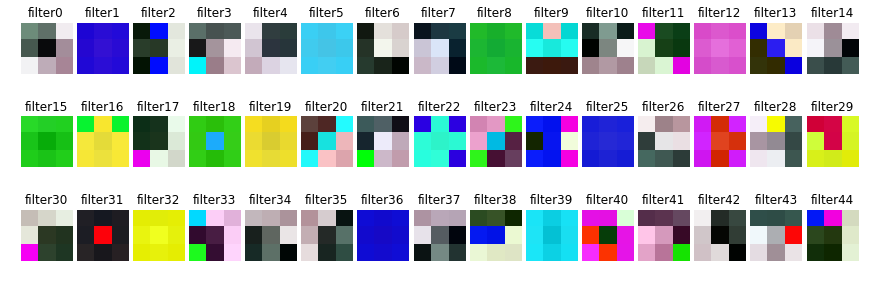

In [5]:
import warnings
warnings.filterwarnings("ignore", module="matplotlib")


fig, ax = plt.subplots(3,15,figsize=(15,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,3):
    for i in range(0, 15):
        ax[j,i].imshow((weights[:,:,:,i+j*15] * 255).astype(np.uint8))
        ax[j,i].set_title('filter'+str(i+j*15))
        ax[j,i].axis('off')
plt.show()

## Maximizing Filter Activity

Berikutnya mari kita bangkitkan gambar yang dapat memaksimasi aktivitas filter. Dengan begitu kita dapat melihat fitur apa yang sebenarnya dilihat oleh filter tersebut



### Random Image
di sini kita mulai input citra adalah citra random

In [0]:
def make_random_image(img_height=128, img_width=128, mean=127, std=10):
    return np.random.normal(loc=mean, scale=std, size=(img_height, img_width, 3))

W0807 01:46:11.205080 140146676000640 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


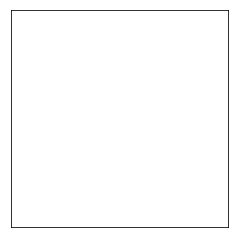

In [9]:
random_img = make_random_image()

plt.imshow(random_img)
plt.xticks([])
plt.yticks([])
plt.show()

### Helper Functions

Berikut beberapa fungsi bantuan untuk mempermudah implementasi
* fungsi mengambil layer berdasarkan nama layer yang bisa dilihat di `model.summary()`
* fungsi menormalisasi citra agar bisa divisualisasikan

In [0]:
def find_layer(model, layer_name):
    for layer in model.layers:
        if layer.name == layer_name:
            return layer
    return None

In [0]:
# convert result data into 0-255 image data
def as_image(x):
    # normalize data
    x -= x.mean()
    x /= (x.std() + 1e-5)
    # set the std to 0.1 and the mean to 0.5
    x *= 0.1
    x += 0.5
    # scale data and clip between 0 and 255 like an image data
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Nudge Image to Activate Filter

Mula-mula kita hitung aktivasi filter dengan gambar acak. Kemudian, menggunakan gradien, kita geser dan menyesuaikan data gambar untuk membuat aktivasi lebih kuat. 

Dengan kata lain, kita mendorong nilai piksel gambar input untuk meningkatkan aktivasi. Proses ini disebut sebagai Gradient Ascent di mana kita memaksimalkan aktivasi dengan menyesuaikan gambar input.

Setelah beberapa pengulangan dari proses ini, output memberi tahu kita gambar seperti apa yang memicu filter untuk diaktifkan dengan kuat, di mana kita dapat memiliki beberapa wawasan tentang hal-hal apa yang terdeteksi oleh filter.

In [0]:
def layer_image(model, layer_name, filter_index, input_img, steps=20, step_size=1.0):
    layer = find_layer(model, layer_name)
    
    # we want to maximize the mean activation of the filter of the layer
    activation = K.mean(layer.output[:, :, :, filter_index])
    
    # the gradients of the activations of the filter of the layer
    grads = K.gradients(activation, model.input)[0]
    
    # normalize the gradients to avoid very small/large gradients
    grads /= K.sqrt(K.mean(K.square(grads))) + 1e-5
    
    # calculate the mean activation and the gradients which depend on the mean activation
    calculate = K.function([model.input], [activation, grads])
        
    # adjust input image suitable for the calculate function
    input_img = np.copy(input_img)    # make a copy to preserve the original
    input_img = np.float64(input_img) # make sure it's float type
    input_data = input_img.reshape((1, *input_img.shape)) # reshape to one record image data

    # maximize the activation using the gradient ascent
    # (nudge the image data with the gradients)
    for i in range(steps):
        _, grads_value = calculate([input_data])
        input_data += grads_value * step_size
    result = input_data[0]
    
    return as_image(result)

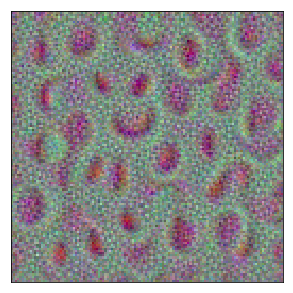

In [14]:
result = layer_image(model, layer_name='block4_conv1', filter_index=0, input_img=random_img)

plt.figure(figsize=(15,5))
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.show()

## Filter Visualization

Setelah kita bisa memvisualisasikan satu filter, maka selanjutnya kita buat fungsi untuk menampilkan visualisasi semua filter dalam suatu layer

In [0]:
def show_filters(layer_name, input_img):
    print(layer_name)
    plt.figure(figsize=(25,5))
    for i in range(20):
        result = layer_image(model, layer_name, filter_index=i, input_img=input_img)    
        plt.subplot(2, 10, i+1)
        plt.imshow(result)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

Mari kita coba lihat visualisasi filter di beberapa layer

block1_conv1


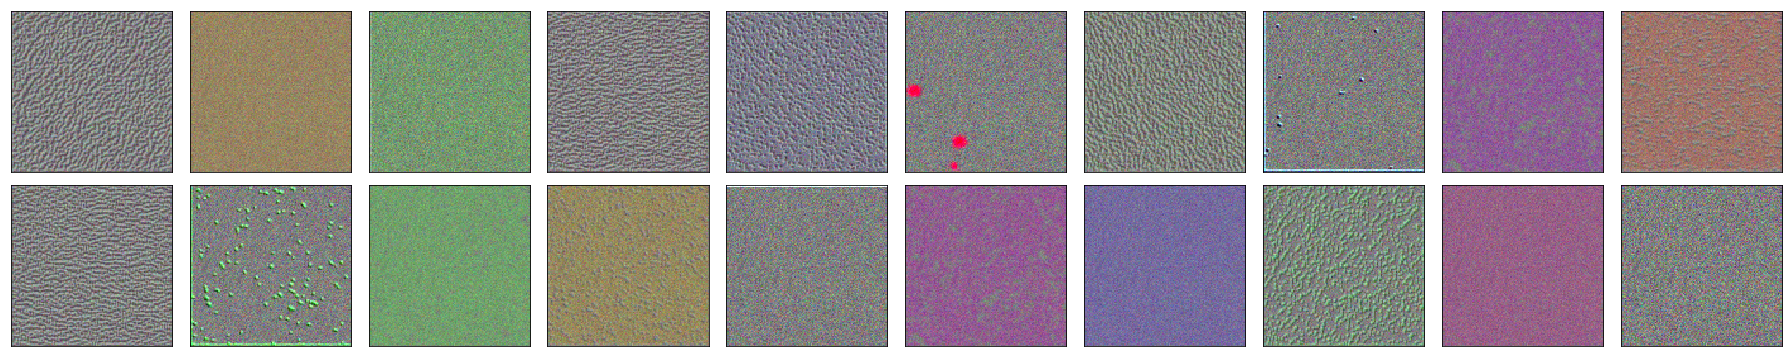

In [16]:
show_filters('block1_conv1', random_img)

block3_conv3


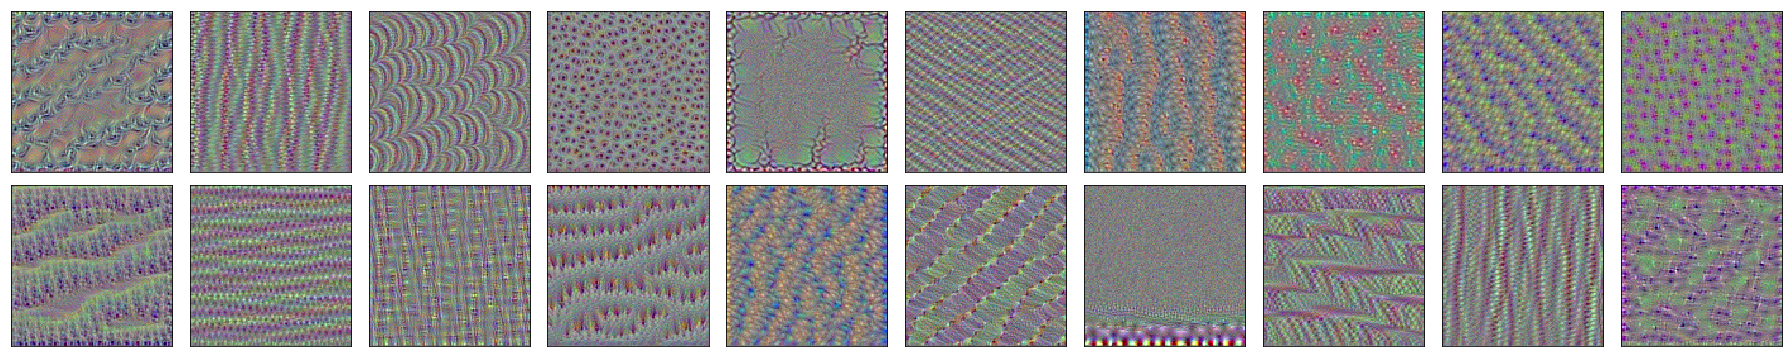

In [17]:
show_filters('block3_conv3', random_img)

block5_conv1


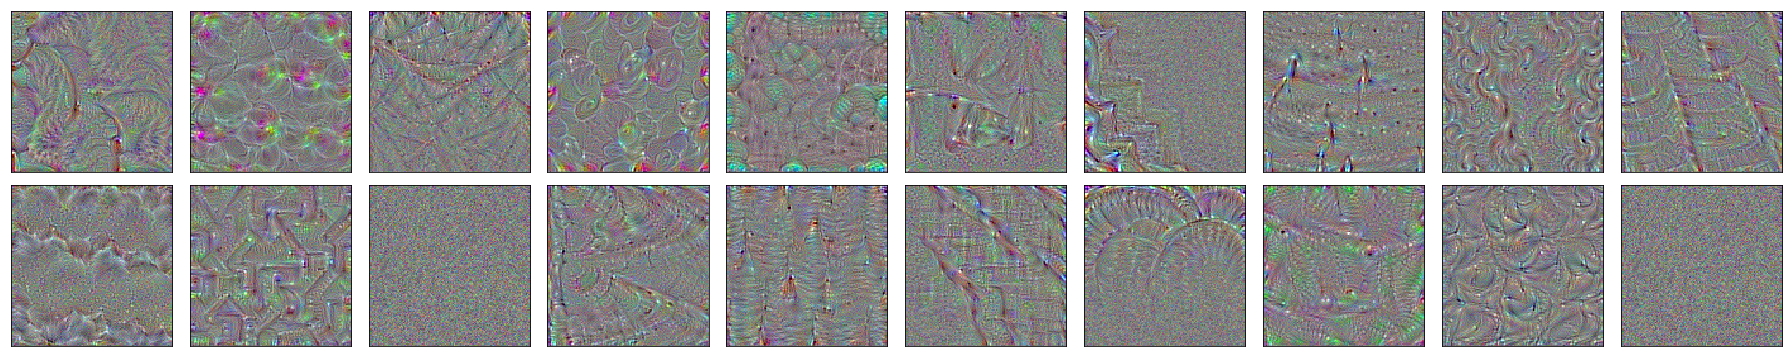

In [18]:
show_filters('block5_conv1', random_img)


Dapat dilihat bahwa makin dalam layer yang dipilih, filter membentuk fitur yang makin detil

## Little Deep Dreams

Berikutnya, kita bisa sedikit bermain Deep Dream

jika input citra random adalah suatu gambar utuh, bagaimanakah hasilnya?

In [19]:
!wget -O 'cat.jpg' 'https://image.ibb.co/bwyWve/persian-cat-content.jpg'

--2019-08-07 01:47:30--  https://image.ibb.co/bwyWve/persian-cat-content.jpg
Resolving image.ibb.co (image.ibb.co)... 64.31.6.154
Connecting to image.ibb.co (image.ibb.co)|64.31.6.154|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 30492 (30K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  29.78K  --.-KB/s    in 0s      

2019-08-07 01:47:30 (247 MB/s) - ‘cat.jpg’ saved [30492/30492]



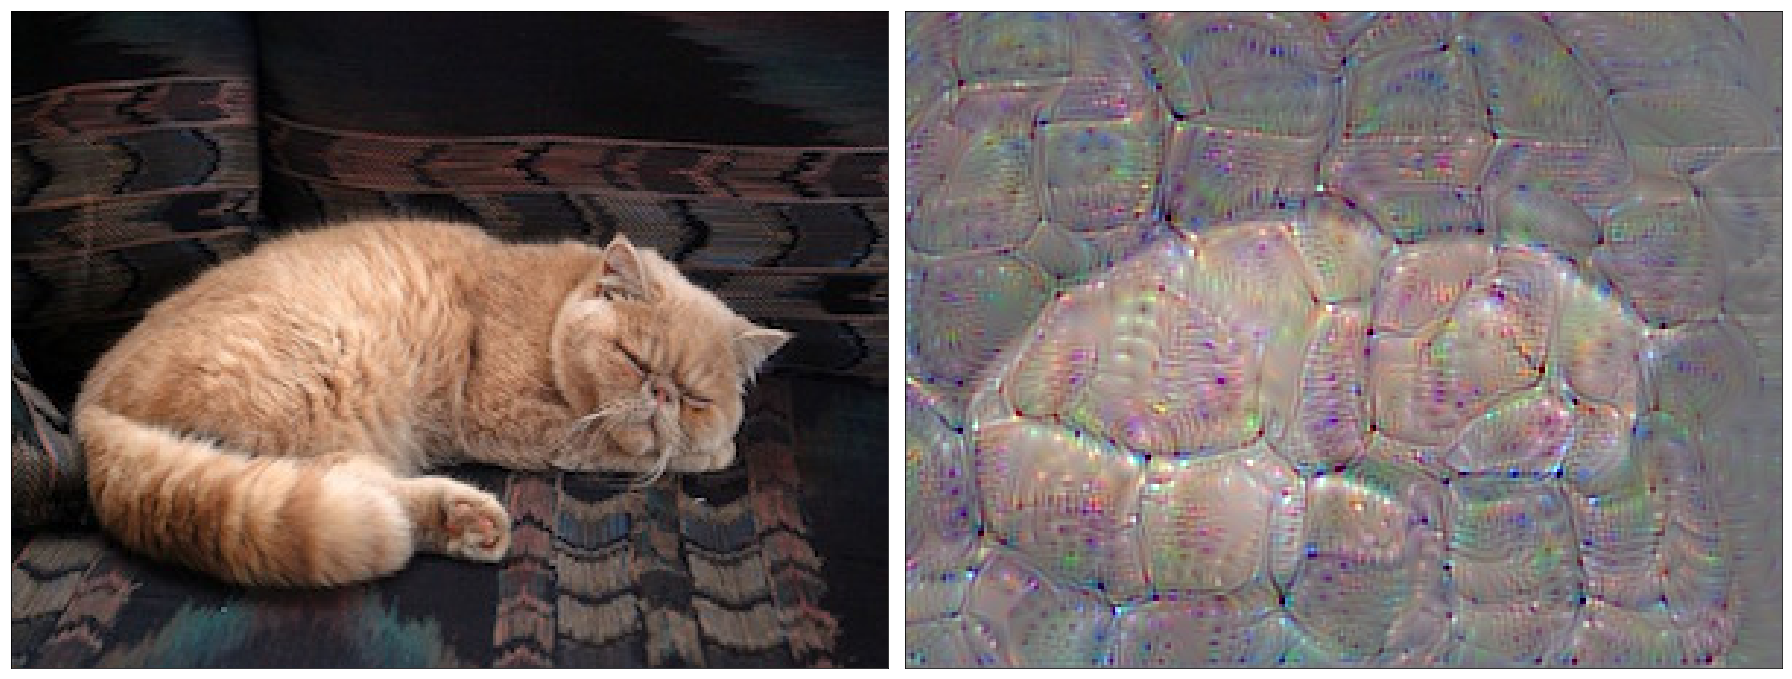

In [20]:
cat_img = plt.imread('cat.jpg')

result = layer_image(model, layer_name='block5_conv3', filter_index=0, input_img=cat_img, steps=100)

plt.figure(figsize=(25,10))
plt.subplot(121)
plt.imshow(cat_img)
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>